# Dask & Performance Tips
<a href="https://dask.pydata.org/en/latest/#"><img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask Parallel Computing"></a>
The [Dask Tutorial](https://www.youtube.com/watch?v=VAuFSo2cIhs&list=PLGVZCDnMOq0rxoq9Nx0B4tqtr891vaCn7&index=20) while not the best demo of [Google Compute Enginge](https://cloud.google.com/compute/) (due to unforseen number of attendees) really demonstrated the power of using [Dask](https://dask.pydata.org/en/latest/) to speed up the processing of not only of algorthms, but even things like reading CSVs into memory. And as we saw in the demo, even without the use of a cluster, code running locally leveraged parallel processing on ones own machine because it **extends the size of convenient datasets from “fits in memory” to “fits on disk”**.

In Jake's [keynote](https://www.youtube.com/watch?v=DifMYH3iuFw&index=14&list=PLGVZCDnMOq0rxoq9Nx0B4tqtr891vaCn7) about current state of Python, he also recommended checking out [Numba](https://numba.pydata.org/) and [Cython](http://docs.cython.org/en/latest/) to sometimes achieve even 500x improvements by compiling the python code to C or LLVM.

<a href="https://fedspendingtransparency.github.io/"><img src="https://fedspendingtransparency.github.io/assets/graphics/dataACT-logo.png"
     align="right"
     width="30%"
     alt="Data Act"></a>
## But first, let's review the USA Spending DATA
The file of **774,648** Transactions for all Awards was generated from https://api.usaspending.gov/api/v1/transactions/ endpoint via Post method so we could set `verbose = true` and get all the fields back for all types of awards. Note that there are a lot of fields!

### An important note about Dask and Data Types
Dask does not load entire dataset to infer data types so it's good practice to set the types yourself. A [Data Dictionary](https://api.usaspending.gov/docs/data-dictionary) can be helpful in understanding what the data is. We don't need to explicitly pass every column when we read the data, but would if we wanted to limit the fields we plan to perform analysis upon. 

#### Open & Honest
* Set data types for Dask
* Set desired columns to use for demo
* Note that I'm not using [parse_dates](http://dask.pydata.org/en/latest/use-cases.html?highlight=parse_dates) on date fields in this demo because like a lot of the data, a lot of date fields are missing, and then I would need to handle NA dates which I don't want to for this demo.

In [6]:
trans_file = 'data/transactions.csv'
data_types = {'id': str,
            'data_source': str,
            'usaspending_unique_transaction_id': str,
            'type': str,
            'type_description': str,
            'period_of_performance_start_date': str,
            'period_of_performance_current_end_date': str,
            'action_type': str,
            'action_date': str,
            'action_type_description': str,
            'federal_action_obligation': float,
            'modification_number': str,
            'description': str,
            'drv_award_transaction_usaspend': str,
            'drv_current_total_award_value_amount_adjustment': float,
            'drv_potential_total_award_value_amount_adjustment': float,
            'award': str,
            'fiscal_year': int,
            'submission': str,
            'awarding_agency_id': str,
            'awarding_agency_toptier_flag': str,
            'awarding_agency_office_agency': str,
            'awarding_agency_toptier_agency_toptier_agency_id': str,
            'awarding_agency_toptier_agency_cgac_code': str,
            'awarding_agency_toptier_agency_fpds_code': str,
            'awarding_agency_toptier_agency_abbreviation': str,
            'awarding_agency_toptier_agency_name': str,
            'awarding_agency_subtier_agency_subtier_agency_id': str,
            'awarding_agency_subtier_agency_subtier_code': str,
            'awarding_agency_subtier_agency_abbreviation': str,
            'awarding_agency_subtier_agency_name': str,
            'funding_agency_id': str,
            'funding_agency_toptier_flag': str,
            'funding_agency_office_agency': str,
            'funding_agency_toptier_agency_toptier_agency_id': str,
            'funding_agency_toptier_agency_cgac_code': str,
            'funding_agency_toptier_agency_fpds_code': str,
            'funding_agency_toptier_agency_abbreviation': str,
            'funding_agency_toptier_agency_name': str,
            'funding_agency_subtier_agency_subtier_agency_id': str,
            'funding_agency_subtier_agency_subtier_code': str,
            'funding_agency_subtier_agency_abbreviation': str,
            'funding_agency_subtier_agency_name': str,
            'recipient_legal_entity_id': str,
            'recipient_data_source': str,
            'recipient_parent_recipient_unique_id': str,
            'recipient_recipient_name': str,
            'recipient_vendor_doing_as_business_name': str,
            'recipient_vendor_phone_number': str,
            'recipient_business_types': str,
            'recipient_business_types_description': str,
            'recipient_recipient_unique_id': str,
            'recipient_limited_liability_corporation': str,
            'recipient_sole_proprietorship': str,
            'recipient_partnership_or_limited_liability_partnership': str,
            'recipient_subchapter_scorporation': str,
            'recipient_foundation': str,
            'recipient_for_profit_organization': str,
            'recipient_nonprofit_organization': str,
            'recipient_corporate_entity_tax_exempt': str,
            'recipient_corporate_entity_not_tax_exempt': str,
            'recipient_other_not_for_profit_organization': str,
            'recipient_sam_exception': str,
            'recipient_city_local_government': str,
            'recipient_county_local_government': str,
            'recipient_inter_municipal_local_government': str,
            'recipient_local_government_owned': str,
            'recipient_municipality_local_government': str,
            'recipient_school_district_local_government': str,
            'recipient_township_local_government': str,
            'recipient_us_state_government': str,
            'recipient_us_federal_government': str,
            'recipient_federal_agency': str,
            'recipient_federally_funded_research_and_development_corp': str,
            'recipient_us_tribal_government': str,
            'recipient_foreign_government': str,
            'recipient_community_developed_corporation_owned_firm': str,
            'recipient_labor_surplus_area_firm': str,
            'recipient_small_agricultural_cooperative': str,
            'recipient_international_organization': str,
            'recipient_us_government_entity': str,
            'recipient_emerging_small_business': str,
            'recipient_c8a_program_participant': str,
            'recipient_sba_certified_8a_joint_venture': str,
            'recipient_dot_certified_disadvantage': str,
            'recipient_self_certified_small_disadvantaged_business': str,
            'recipient_historically_underutilized_business_zone': str,
            'recipient_small_disadvantaged_business': str,
            'recipient_historically_black_college': str,
            'recipient_c1862_land_grant_college': str,
            'recipient_c1890_land_grant_college': str,
            'recipient_c1994_land_grant_college': str,
            'recipient_minority_institution': str,
            'recipient_private_university_or_college': str,
            'recipient_school_of_forestry': str,
            'recipient_state_controlled_institution_of_higher_learning': str,
            'recipient_tribal_college': str,
            'recipient_veterinary_college': str,
            'recipient_educational_institution': str,
            'recipient_alaskan_native_servicing_institution': str,
            'recipient_community_development_corporation': str,
            'recipient_native_hawaiian_servicing_institution': str,
            'recipient_domestic_shelter': str,
            'recipient_manufacturer_of_goods': str,
            'recipient_hospital_flag': str,
            'recipient_veterinary_hospital': str,
            'recipient_hispanic_servicing_institution': str,
            'recipient_woman_owned_business': str,
            'recipient_minority_owned_business': str,
            'recipient_women_owned_small_business': str,
            'recipient_economically_disadvantaged_women_owned_small_business': str,
            'recipient_joint_venture_women_owned_small_business': str,
            'recipient_joint_venture_economic_disadvantaged_women_owned_small_bus': str,
            'recipient_veteran_owned_business': str,
            'recipient_service_disabled_veteran_owned_business': str,
            'recipient_contracts': str,
            'recipient_grants': str,
            'recipient_receives_contracts_and_grants': str,
            'recipient_airport_authority': str,
            'recipient_council_of_governments': str,
            'recipient_housing_authorities_public_tribal': str,
            'recipient_interstate_entity': str,
            'recipient_planning_commission': str,
            'recipient_port_authority': str,
            'recipient_transit_authority': str,
            'recipient_foreign_owned_and_located': str,
            'recipient_american_indian_owned_business': str,
            'recipient_alaskan_native_owned_corporation_or_firm': str,
            'recipient_indian_tribe_federally_recognized': str,
            'recipient_native_hawaiian_owned_business': str,
            'recipient_tribally_owned_business': str,
            'recipient_asian_pacific_american_owned_business': str,
            'recipient_black_american_owned_business': str,
            'recipient_hispanic_american_owned_business': str,
            'recipient_native_american_owned_business': str,
            'recipient_subcontinent_asian_asian_indian_american_owned_business': str,
            'recipient_other_minority_owned_business': str,
            'recipient_us_local_government': str,
            'recipient_undefinitized_action': str,
            'recipient_domestic_or_foreign_entity': str,
            'recipient_domestic_or_foreign_entity_description': str,
            'recipient_division_name': str,
            'recipient_division_number': str,
            'recipient_reporting_period_start': str,
            'recipient_reporting_period_end': str,
            'recipient_city_township_government': str,
            'recipient_special_district_government': str,
            'recipient_small_business': str,
            'recipient_small_business_description': str,
            'recipient_individual': str,
            'recipient_location_location_id': str,
            'recipient_location_data_source': str,
            'recipient_location_country_name': str,
            'recipient_location_state_code': str,
            'recipient_location_state_name': str,
            'recipient_location_state_description': str,
            'recipient_location_city_name': str,
            'recipient_location_city_code': str,
            'recipient_location_county_name': str,
            'recipient_location_county_code': str,
            'recipient_location_address_line1': str,
            'recipient_location_address_line2': str,
            'recipient_location_address_line3': str,
            'recipient_location_foreign_location_description': str,
            'recipient_location_zip4': str,
            'recipient_location_zip_4a': str,
            'recipient_location_congressional_code': str,
            'recipient_location_performance_code': str,
            'recipient_location_zip_last4': str,
            'recipient_location_zip5': str,
            'recipient_location_foreign_postal_code': str,
            'recipient_location_foreign_province': str,
            'recipient_location_foreign_city_name': str,
            'recipient_location_reporting_period_start': str,
            'recipient_location_reporting_period_end': str,
            'recipient_location_place_of_performance_flag': str,
            'recipient_location_recipient_flag': str,
            'recipient_location_location_country_code': str,
            'recipient_officers_legal_entity': str,
            'recipient_officers_officer_1_name': str,
            'recipient_officers_officer_1_amount': str,
            'recipient_officers_officer_2_name': str,
            'recipient_officers_officer_2_amount': str,
            'recipient_officers_officer_3_name': str,
            'recipient_officers_officer_3_amount': str,
            'recipient_officers_officer_4_name': str,
            'recipient_officers_officer_4_amount': str,
            'recipient_officers_officer_5_name': str,
            'recipient_officers_officer_5_amount': str,
            'place_of_performance_location_id': str,
            'place_of_performance_data_source': str,
            'place_of_performance_country_name': str,
            'place_of_performance_state_code': str,
            'place_of_performance_state_name': str,
            'place_of_performance_state_description': str,
            'place_of_performance_city_name': str,
            'place_of_performance_county_name': str,
            'place_of_performance_county_code': str,
            'place_of_performance_address_line1': str,
            'place_of_performance_address_line2': str,
            'place_of_performance_address_line3': str,
            'place_of_performance_foreign_location_description': str,
            'place_of_performance_zip4': str,
            'place_of_performance_zip_4a': str,
            'place_of_performance_congressional_code': str,
            'place_of_performance_performance_code': str,
            'place_of_performance_zip_last4': str,
            'place_of_performance_zip5': str,
            'place_of_performance_foreign_postal_code': str,
            'place_of_performance_foreign_province': str,
            'place_of_performance_foreign_city_name': str,
            'place_of_performance_reporting_period_start': str,
            'place_of_performance_reporting_period_end': str,
            'place_of_performance_place_of_performance_flag': str,
            'place_of_performance_recipient_flag': str,
            'place_of_performance_location_country_code': str,
            'assistance_data_transaction': str,
            'assistance_data_data_source': str,
            'assistance_data_fain': str,
            'assistance_data_uri': str,
            'assistance_data_cfda_number': str,
            'assistance_data_cfda_title': str,
            'assistance_data_business_funds_indicator': str,
            'assistance_data_business_funds_indicator_description': str,
            'assistance_data_non_federal_funding_amount': str,
            'assistance_data_total_funding_amount': str,
            'assistance_data_face_value_loan_guarantee': str,
            'assistance_data_original_loan_subsidy_cost': str,
            'assistance_data_record_type': str,
            'assistance_data_record_type_description': str,
            'assistance_data_correction_late_delete_indicator': str,
            'assistance_data_correction_late_delete_indicator_description': str,
            'assistance_data_fiscal_year_and_quarter_correction': str,
            'assistance_data_sai_number': str,
            'assistance_data_drv_federal_funding_amount': str,
            'assistance_data_drv_award_finance_assistance_type_label': str,
            'assistance_data_reporting_period_start': str,
            'assistance_data_reporting_period_end': str,
            'assistance_data_submitted_type': str,
            'assistance_data_period_of_performance_start_date': str,
            'assistance_data_period_of_performance_current_end_date': str,
            'assistance_data_submission': str,
            'assistance_data_cfda_program_number': str,
            'assistance_data_cfda_data_source': str,
            'assistance_data_cfda_program_title': str,
            'assistance_data_cfda_popular_name': str,
            'assistance_data_cfda_federal_agency': str,
            'assistance_data_cfda_authorization': str,
            'assistance_data_cfda_objectives': str,
            'assistance_data_cfda_types_of_assistance': str,
            'assistance_data_cfda_uses_and_use_restrictions': str,
            'assistance_data_cfda_applicant_eligibility': str,
            'assistance_data_cfda_beneficiary_eligibility': str,
            'assistance_data_cfda_credentials_documentation': str,
            'assistance_data_cfda_pre_application_coordination': str,
            'assistance_data_cfda_application_procedures': str,
            'assistance_data_cfda_award_procedure': str,
            'assistance_data_cfda_deadlines': str,
            'assistance_data_cfda_range_of_approval_disapproval_time': str,
            'assistance_data_cfda_website_address': str,
            'assistance_data_cfda_formula_and_matching_requirements': str,
            'assistance_data_cfda_length_and_time_phasing_of_assistance': str,
            'assistance_data_cfda_reports': str,
            'assistance_data_cfda_audits': str,
            'assistance_data_cfda_records': str,
            'assistance_data_cfda_account_identification': str,
            'assistance_data_cfda_obligations': float,
            'assistance_data_cfda_range_and_average_of_financial_assistance': str,
            'assistance_data_cfda_appeals': str,
            'assistance_data_cfda_renewals': str,
            'assistance_data_cfda_program_accomplishments': str,
            'assistance_data_cfda_regulations_guidelines_and_literature': str,
            'assistance_data_cfda_regional_or_local_office': str,
            'assistance_data_cfda_headquarters_office': str,
            'assistance_data_cfda_related_programs': str,
            'assistance_data_cfda_examples_of_funded_projects': str,
            'assistance_data_cfda_criteria_for_selecting_proposals': str,
            'assistance_data_cfda_url': str,
            'assistance_data_cfda_recovery': str,
            'assistance_data_cfda_omb_agency_code': str,
            'assistance_data_cfda_omb_bureau_code': str,
            'contract_data_piid': str,
            'contract_data_parent_award_id': str,
            'contract_data_cost_or_pricing_data': str,
            'contract_data_type_of_contract_pricing': str,
            'contract_data_type_of_contract_pricing_description': str,
            'contract_data_naics': str,
            'contract_data_naics_description': str,
            'contract_data_idv_type_description': str,
            'contract_data_multiple_or_single_award_idv_description': str,
            'contract_data_type_of_idc_description': str,
            'contract_data_commercial_item_acquisition_procedures_description': str,
            'contract_data_contingency_humanitarian_or_peacekeeping_operation_description': str,
            'contract_data_contract_bundling_description': str,
            'contract_data_contract_financing_description': str,
            'contract_data_cost_accounting_standards_description': str,
            'contract_data_davis_bacon_act_description': str,
            'contract_data_evaluated_preference_description': str,
            'contract_data_extent_competed_description': str,
            'contract_data_fed_biz_opps_description': str,
            'contract_data_foreign_funding_description': str,
            'contract_data_information_technology_commercial_item_category_description': str,
            'contract_data_interagency_contracting_authority_description': str,
            'contract_data_national_interest_action_description': str,
            'contract_data_performance_based_service_acquisition_description': str,
            'contract_data_place_of_manufacture_description': str,
            'contract_data_product_or_service_code': str,
            'contract_data_recovered_materials_sustainability_description': str,
            'contract_data_research_description': str,
            'contract_data_sea_transportation_description': str,
            'contract_data_service_contract_act_description': str,
            'contract_data_solicitation_procedures_description': str,
            'contract_data_fair_opportunity_limited_sources_description': str,
            'contract_data_subcontracting_plan_description': str,
            'contract_data_type_set_aside_description': str,
            'contract_data_epa_designated_product_description': str
           }
trans_cols = ['id','data_source','usaspending_unique_transaction_id','type','type_description',
              'period_of_performance_start_date','period_of_performance_current_end_date',
              'action_date','action_type','action_type_description','federal_action_obligation',
              'modification_number','description','drv_award_transaction_usaspend',
              'drv_current_total_award_value_amount_adjustment','drv_potential_total_award_value_amount_adjustment',
              'last_modified_date','certified_date','create_date','update_date','award','fiscal_year','submission',
              'awarding_agency_id','awarding_agency_create_date','awarding_agency_update_date',
              'awarding_agency_toptier_flag','awarding_agency_office_agency','awarding_agency_toptier_agency_toptier_agency_id',
              'awarding_agency_toptier_agency_create_date','awarding_agency_toptier_agency_update_date',
              'awarding_agency_toptier_agency_cgac_code','awarding_agency_toptier_agency_fpds_code',
              'awarding_agency_toptier_agency_abbreviation','awarding_agency_toptier_agency_name',
              'awarding_agency_subtier_agency_subtier_agency_id','awarding_agency_subtier_agency_create_date',
              'awarding_agency_subtier_agency_update_date','awarding_agency_subtier_agency_subtier_code',
              'awarding_agency_subtier_agency_abbreviation','awarding_agency_subtier_agency_name','funding_agency_id',
              'funding_agency_create_date','funding_agency_update_date','funding_agency_toptier_flag',
              'funding_agency_office_agency','funding_agency_toptier_agency_toptier_agency_id',
              'funding_agency_toptier_agency_create_date','funding_agency_toptier_agency_update_date',
              'funding_agency_toptier_agency_cgac_code','funding_agency_toptier_agency_fpds_code',
              'funding_agency_toptier_agency_abbreviation','funding_agency_toptier_agency_name',
              'funding_agency_subtier_agency_subtier_agency_id','funding_agency_subtier_agency_create_date',
              'funding_agency_subtier_agency_update_date','funding_agency_subtier_agency_subtier_code',
              'funding_agency_subtier_agency_abbreviation','funding_agency_subtier_agency_name',
              'recipient_legal_entity_id','recipient_data_source','recipient_parent_recipient_unique_id',
              'recipient_recipient_name','recipient_vendor_doing_as_business_name','recipient_vendor_phone_number',
              'recipient_business_types','recipient_business_types_description','recipient_recipient_unique_id',
              'recipient_limited_liability_corporation','recipient_sole_proprietorship',
              'recipient_partnership_or_limited_liability_partnership','recipient_subchapter_scorporation',
              'recipient_foundation','recipient_for_profit_organization','recipient_nonprofit_organization',
              'recipient_corporate_entity_tax_exempt','recipient_corporate_entity_not_tax_exempt',
              'recipient_other_not_for_profit_organization','recipient_sam_exception','recipient_city_local_government',
              'recipient_county_local_government','recipient_inter_municipal_local_government',
              'recipient_local_government_owned','recipient_municipality_local_government',
              'recipient_school_district_local_government','recipient_township_local_government',
              'recipient_us_state_government','recipient_us_federal_government','recipient_federal_agency',
              'recipient_federally_funded_research_and_development_corp','recipient_us_tribal_government',
              'recipient_foreign_government','recipient_community_developed_corporation_owned_firm',
              'recipient_labor_surplus_area_firm','recipient_small_agricultural_cooperative',
              'recipient_international_organization','recipient_us_government_entity',
              'recipient_emerging_small_business','recipient_c8a_program_participant',
              'recipient_sba_certified_8a_joint_venture','recipient_dot_certified_disadvantage',
              'recipient_self_certified_small_disadvantaged_business','recipient_historically_underutilized_business_zone',
              'recipient_small_disadvantaged_business','recipient_historically_black_college','recipient_c1862_land_grant_college',
              'recipient_c1890_land_grant_college','recipient_c1994_land_grant_college','recipient_minority_institution',
              'recipient_private_university_or_college','recipient_school_of_forestry','recipient_state_controlled_institution_of_higher_learning',
              'recipient_tribal_college','recipient_veterinary_college','recipient_educational_institution','recipient_alaskan_native_servicing_institution',
              'recipient_community_development_corporation','recipient_native_hawaiian_servicing_institution',
              'recipient_domestic_shelter','recipient_manufacturer_of_goods','recipient_hospital_flag',
              'recipient_veterinary_hospital','recipient_hispanic_servicing_institution','recipient_woman_owned_business',
              'recipient_minority_owned_business','recipient_women_owned_small_business','recipient_economically_disadvantaged_women_owned_small_business',
              'recipient_joint_venture_women_owned_small_business','recipient_joint_venture_economic_disadvantaged_women_owned_small_bus',
              'recipient_veteran_owned_business','recipient_service_disabled_veteran_owned_business','recipient_contracts','recipient_grants',
              'recipient_receives_contracts_and_grants','recipient_airport_authority','recipient_council_of_governments',
              'recipient_housing_authorities_public_tribal','recipient_interstate_entity','recipient_planning_commission',
              'recipient_port_authority','recipient_transit_authority','recipient_foreign_owned_and_located','recipient_american_indian_owned_business',
              'recipient_alaskan_native_owned_corporation_or_firm','recipient_indian_tribe_federally_recognized','recipient_native_hawaiian_owned_business',
              'recipient_tribally_owned_business','recipient_asian_pacific_american_owned_business','recipient_black_american_owned_business',
              'recipient_hispanic_american_owned_business','recipient_native_american_owned_business',
              'recipient_subcontinent_asian_asian_indian_american_owned_business','recipient_other_minority_owned_business',
              'recipient_us_local_government','recipient_undefinitized_action','recipient_domestic_or_foreign_entity',
              'recipient_domestic_or_foreign_entity_description','recipient_division_name','recipient_division_number',
              'recipient_last_modified_date','recipient_certified_date','recipient_reporting_period_start','recipient_reporting_period_end',
              'recipient_create_date','recipient_update_date','recipient_city_township_government','recipient_special_district_government',
              'recipient_small_business','recipient_small_business_description','recipient_individual','recipient_location_location_id',
              'recipient_location_data_source','recipient_location_country_name','recipient_location_state_code','recipient_location_state_name',
              'recipient_location_state_description','recipient_location_city_name','recipient_location_city_code','recipient_location_county_name',
              'recipient_location_county_code','recipient_location_address_line1','recipient_location_address_line2','recipient_location_address_line3',
              'recipient_location_foreign_location_description','recipient_location_zip4','recipient_location_zip_4a','recipient_location_congressional_code',
              'recipient_location_performance_code','recipient_location_zip_last4','recipient_location_zip5','recipient_location_foreign_postal_code',
              'recipient_location_foreign_province','recipient_location_foreign_city_name','recipient_location_reporting_period_start',
              'recipient_location_reporting_period_end','recipient_location_last_modified_date','recipient_location_certified_date',
              'recipient_location_create_date','recipient_location_update_date','recipient_location_place_of_performance_flag',
              'recipient_location_recipient_flag','recipient_location_location_country_code','recipient_officers_legal_entity',
              'recipient_officers_officer_1_name','recipient_officers_officer_1_amount','recipient_officers_officer_2_name',
              'recipient_officers_officer_2_amount','recipient_officers_officer_3_name','recipient_officers_officer_3_amount',
              'recipient_officers_officer_4_name','recipient_officers_officer_4_amount','recipient_officers_officer_5_name',
              'recipient_officers_officer_5_amount','recipient_officers_update_date','place_of_performance_location_id',
              'place_of_performance_data_source','place_of_performance_country_name','place_of_performance_state_code',
              'place_of_performance_state_name','place_of_performance_state_description','place_of_performance_city_name',
              'place_of_performance_county_name','place_of_performance_county_code','place_of_performance_address_line1',
              'place_of_performance_address_line2','place_of_performance_address_line3','place_of_performance_foreign_location_description',
              'place_of_performance_zip4','place_of_performance_zip_4a','place_of_performance_congressional_code',
              'place_of_performance_performance_code','place_of_performance_zip_last4','place_of_performance_zip5','place_of_performance_foreign_postal_code',
              'place_of_performance_foreign_province','place_of_performance_foreign_city_name','place_of_performance_reporting_period_start',
              'place_of_performance_reporting_period_end','place_of_performance_last_modified_date','place_of_performance_certified_date',
              'place_of_performance_create_date','place_of_performance_update_date','place_of_performance_place_of_performance_flag',
              'place_of_performance_recipient_flag','place_of_performance_location_country_code','assistance_data_transaction',
              'assistance_data_data_source','assistance_data_fain','assistance_data_uri','assistance_data_cfda_number',
              'assistance_data_cfda_title','assistance_data_business_funds_indicator','assistance_data_business_funds_indicator_description',
              'assistance_data_non_federal_funding_amount','assistance_data_total_funding_amount','assistance_data_face_value_loan_guarantee',
              'assistance_data_original_loan_subsidy_cost','assistance_data_record_type','assistance_data_record_type_description',
              'assistance_data_correction_late_delete_indicator','assistance_data_correction_late_delete_indicator_description',
              'assistance_data_fiscal_year_and_quarter_correction','assistance_data_sai_number','assistance_data_drv_federal_funding_amount',
              'assistance_data_drv_award_finance_assistance_type_label','assistance_data_reporting_period_start','assistance_data_reporting_period_end',
              'assistance_data_last_modified_date','assistance_data_submitted_type','assistance_data_certified_date','assistance_data_create_date',
              'assistance_data_update_date','assistance_data_period_of_performance_start_date','assistance_data_period_of_performance_current_end_date',
              'assistance_data_submission','assistance_data_cfda_program_number','assistance_data_cfda_data_source','assistance_data_cfda_program_title',
              'assistance_data_cfda_popular_name','assistance_data_cfda_federal_agency','assistance_data_cfda_authorization',
              'assistance_data_cfda_objectives','assistance_data_cfda_types_of_assistance','assistance_data_cfda_uses_and_use_restrictions',
              'assistance_data_cfda_applicant_eligibility','assistance_data_cfda_beneficiary_eligibility','assistance_data_cfda_credentials_documentation',
              'assistance_data_cfda_pre_application_coordination','assistance_data_cfda_application_procedures','assistance_data_cfda_award_procedure',
              'assistance_data_cfda_deadlines','assistance_data_cfda_range_of_approval_disapproval_time','assistance_data_cfda_website_address',
              'assistance_data_cfda_formula_and_matching_requirements','assistance_data_cfda_length_and_time_phasing_of_assistance','assistance_data_cfda_reports',
              'assistance_data_cfda_audits','assistance_data_cfda_records','assistance_data_cfda_account_identification','assistance_data_cfda_obligations',
              'assistance_data_cfda_range_and_average_of_financial_assistance','assistance_data_cfda_appeals','assistance_data_cfda_renewals',
              'assistance_data_cfda_program_accomplishments','assistance_data_cfda_regulations_guidelines_and_literature','assistance_data_cfda_regional_or_local_office',
              'assistance_data_cfda_headquarters_office','assistance_data_cfda_related_programs','assistance_data_cfda_examples_of_funded_projects','assistance_data_cfda_criteria_for_selecting_proposals',
              'assistance_data_cfda_url','assistance_data_cfda_recovery','assistance_data_cfda_omb_agency_code','assistance_data_cfda_omb_bureau_code',
              'assistance_data_cfda_published_date','assistance_data_cfda_archived_date','assistance_data_cfda_create_date','assistance_data_cfda_update_date',
              'contract_data_piid','contract_data_parent_award_id','contract_data_cost_or_pricing_data','contract_data_type_of_contract_pricing',
              'contract_data_type_of_contract_pricing_description','contract_data_naics','contract_data_naics_description','contract_data_idv_type_description',
              'contract_data_multiple_or_single_award_idv_description','contract_data_type_of_idc_description','contract_data_commercial_item_acquisition_procedures_description',
              'contract_data_contingency_humanitarian_or_peacekeeping_operation_description','contract_data_contract_bundling_description','contract_data_contract_financing_description',
              'contract_data_cost_accounting_standards_description','contract_data_davis_bacon_act_description','contract_data_evaluated_preference_description',
              'contract_data_extent_competed_description','contract_data_fed_biz_opps_description','contract_data_foreign_funding_description',
              'contract_data_information_technology_commercial_item_category_description','contract_data_interagency_contracting_authority_description',
              'contract_data_national_interest_action_description','contract_data_performance_based_service_acquisition_description','contract_data_place_of_manufacture_description',
              'contract_data_product_or_service_code','contract_data_recovered_materials_sustainability_description','contract_data_research_description',
              'contract_data_sea_transportation_description','contract_data_service_contract_act_description','contract_data_solicitation_procedures_description',
              'contract_data_fair_opportunity_limited_sources_description','contract_data_subcontracting_plan_description',
              'contract_data_type_set_aside_description','contract_data_epa_designated_product_description']

## Dask Example
One distinction made by the Dask folks when asked to compare with Spark is that Dask plays well with Pandas, especially with [data frames](http://dask.pydata.org/en/latest/dataframe-overview.html).

Dask can read from [AWS S3 buckets](http://dask.pydata.org/en/latest/dataframe-create.html?highlight=read_s3) as well from [parquet and hdf](http://dask.pydata.org/en/latest/dataframe-create.html?highlight=compression) so, really big data!

To get started, install [Anaconda](https://www.continuum.io/downloads) and then run `conda install graphviz` or `brew install graphviz`

## Load local file with Dask

In [18]:
#!pip3 install dask

In [7]:
%%time
import dask.dataframe as dd

df = dd.read_csv(trans_file, dtype=data_types, usecols=trans_cols)
print(len(df), 'rows')
# Dask can also read from S3 file if stored there like so
# df = dd.read_csv(s3_file, storage_options={'anon': True}, dtype=data_types, usecols=trans_cols)

774648
CPU times: user 34 s, sys: 5.18 s, total: 39.2 s
Wall time: 31 s


## Compare to Pandas

In [8]:
%%time
import numpy as np
import pandas as pd

p_df = pd.read_csv(trans_file,dtype=data_types, usecols=trans_cols)

CPU times: user 26.5 s, sys: 6.51 s, total: 33 s
Wall time: 35.9 s


# Cool - Dask is Faster though has not read all data yet

## Now perform a Group By operation (aggregation)
Get the largest Federal Obligation by Award Type

In [9]:
%time
z = df.groupby(df.type_description).federal_action_obligation.max()

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10 µs


### Pretty fast, but still hasn't executed on data yet
Now, let's get the results with compute method

In [10]:
%%time
# runs computation using a local thread pool
z.compute()

CPU times: user 32.4 s, sys: 4.79 s, total: 37.2 s
Wall time: 29 s


type_description
BPA Call                                1.959985e+07
Block Grant                             8.949351e+08
Cooperative Agreement                   5.011797e+07
Definitive Contract                     4.671503e+08
Delivery Order                          9.600000e+08
Direct Loan                             0.000000e+00
Direct Payment for Specified Use        1.173058e+10
Direct Payment with Unrestricted Use    2.006276e+08
Formula Grant                           1.370702e+10
Grant for Research                      2.972194e+06
Guaranteed/Insured Loan                 0.000000e+00
Insurance                               9.132735e+08
Other Financial Assistance              6.695914e+08
Project Grant                           5.000000e+08
Purchase Order                          2.400340e+08
Training Grant                          4.669000e+04
Unknown Type                            1.685434e+06
Funded Space Act Agreement              2.300000e+07
Name: federal_action_obligati

## Pandas executes fast because data has been loaded in memory

In [11]:
%time
p_df.groupby(p_df.type_description).federal_action_obligation.max()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10 µs


type_description
BPA Call                                1.959985e+07
Block Grant                             8.949351e+08
Cooperative Agreement                   5.011797e+07
Definitive Contract                     4.671503e+08
Delivery Order                          9.600000e+08
Direct Loan                             0.000000e+00
Direct Payment for Specified Use        1.173058e+10
Direct Payment with Unrestricted Use    2.006276e+08
Formula Grant                           1.370702e+10
Funded Space Act Agreement              2.300000e+07
Grant for Research                      2.972194e+06
Guaranteed/Insured Loan                 0.000000e+00
Insurance                               9.132735e+08
Other Financial Assistance              6.695914e+08
Project Grant                           5.000000e+08
Purchase Order                          2.400340e+08
Training Grant                          4.669000e+04
Unknown Type                            1.685434e+06
Name: federal_action_obligati

## We can visualize the Parallel Processing Plan
Dask [dataframes](https://dask.pydata.org/en/latest/dataframe-overview.html) loads data into smaller dataframes that are then computed in parallel using all cores available before aggregating data back together.

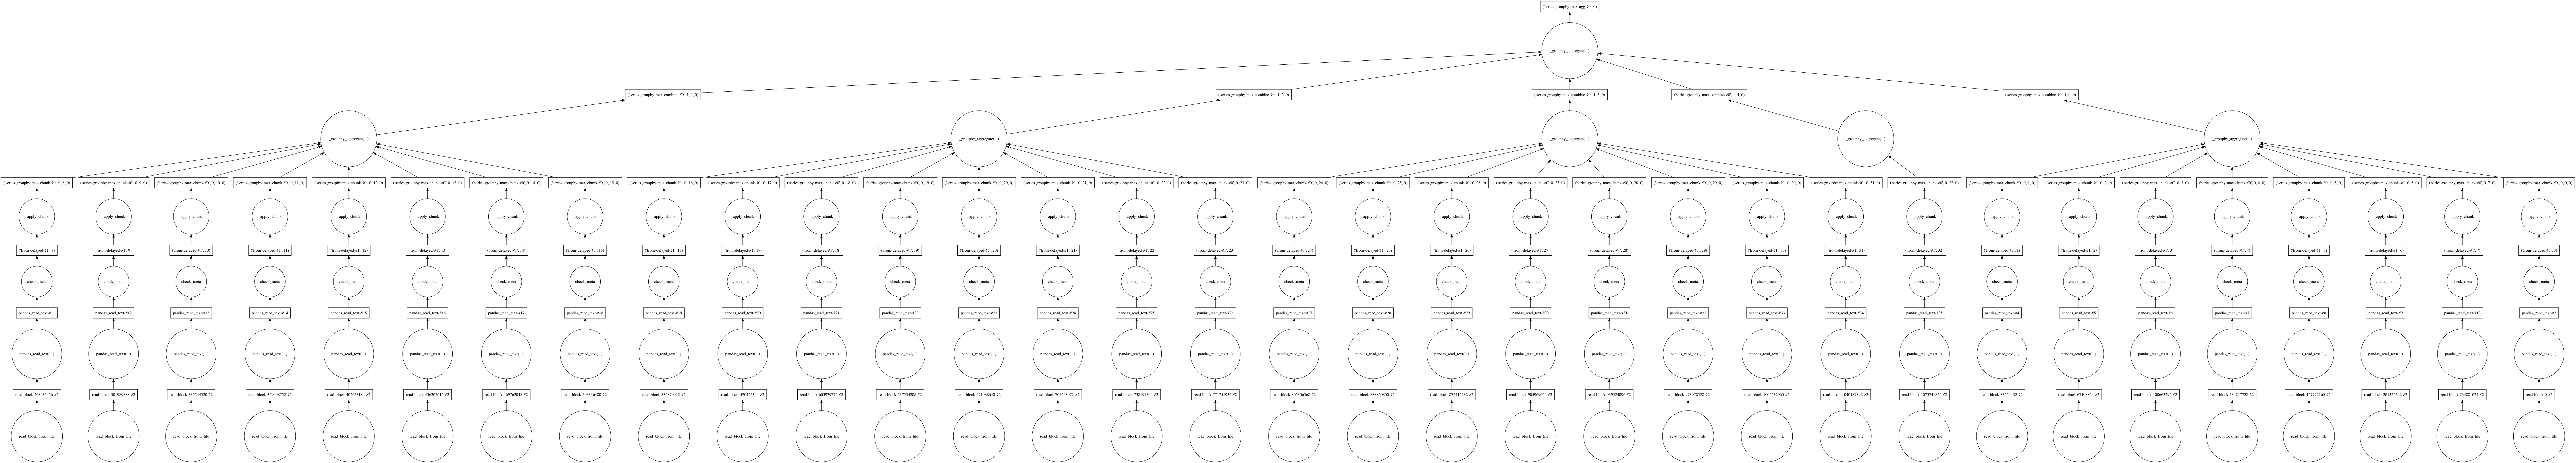

In [19]:
# Look at the task graph for `z`
z.visualize()

In [20]:
# persist Dask dataframe in memory
x = z.persist()

## Once we persist the Dask data into memory, Very Fast
Faster than Pandas again!

In [21]:
%%time
# run from memory
x.compute()

CPU times: user 637 µs, sys: 161 µs, total: 798 µs
Wall time: 726 µs


type_description
BPA Call                                1.959985e+07
Block Grant                             8.949351e+08
Cooperative Agreement                   5.011797e+07
Definitive Contract                     4.671503e+08
Delivery Order                          9.600000e+08
Direct Loan                             0.000000e+00
Direct Payment for Specified Use        1.173058e+10
Direct Payment with Unrestricted Use    2.006276e+08
Formula Grant                           1.370702e+10
Grant for Research                      2.972194e+06
Guaranteed/Insured Loan                 0.000000e+00
Insurance                               9.132735e+08
Other Financial Assistance              6.695914e+08
Project Grant                           5.000000e+08
Purchase Order                          2.400340e+08
Training Grant                          4.669000e+04
Unknown Type                            1.685434e+06
Funded Space Act Agreement              2.300000e+07
Name: federal_action_obligati

# Final Notes
Check out the [tutorial examples](https://github.com/jcrist/dask-tutorial-pydata-seattle-2017)!